In [163]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [164]:
import pandas as pd

In [165]:
target = '202010'

In [166]:
df = pd.read_table(f'data/parsed/{target}.tsv', index_col=0)
df

,date,time,mothermilk,milk,expressedmilk,small,big,sleep
0,2020-10-01,01:00:00,11.0,NaN,NaN,NaN,NaN,NaN
1,2020-10-01,03:10:00,30.0,NaN,NaN,NaN,NaN,NaN
2,2020-10-01,06:45:00,NaN,NaN,NaN,NaN,NaN,0.0
3,2020-10-01,06:45:00,NaN,NaN,NaN,1.0,NaN,NaN
4,2020-10-01,06:45:00,23.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1273,2020-10-31,23:15:00,NaN,NaN,NaN,1.0,NaN,NaN
1274,2020-10-31,23:40:00,NaN,NaN,NaN,NaN,NaN,1.0
1275,2020-10-31,23:40:00,230.0,NaN,NaN,NaN,NaN,NaN
1276,2020-10-31,23:40:00,NaN,NaN,NaN,1.0,NaN,NaN


datetime indexをセット

In [167]:
df['datetime'] = pd.to_datetime(df['date'] + 'T' + df['time'])
df = df.set_index('datetime')
df

,date,time,mothermilk,milk,expressedmilk,small,big,sleep
datetime,,,,,,,,
2020-10-01 01:00:00,2020-10-01,01:00:00,11.0,NaN,NaN,NaN,NaN,NaN
2020-10-01 03:10:00,2020-10-01,03:10:00,30.0,NaN,NaN,NaN,NaN,NaN
2020-10-01 06:45:00,2020-10-01,06:45:00,NaN,NaN,NaN,NaN,NaN,0.0
2020-10-01 06:45:00,2020-10-01,06:45:00,NaN,NaN,NaN,1.0,NaN,NaN
2020-10-01 06:45:00,2020-10-01,06:45:00,23.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-10-31 23:15:00,2020-10-31,23:15:00,NaN,NaN,NaN,1.0,NaN,NaN
2020-10-31 23:40:00,2020-10-31,23:40:00,NaN,NaN,NaN,NaN,NaN,1.0
2020-10-31 23:40:00,2020-10-31,23:40:00,230.0,NaN,NaN,NaN,NaN,NaN


睡眠時間 (分) をsleep_minutes列にセット

In [168]:
import numpy as np

sleep_series = pd.Series()
sleep_in_time = 0
df['sleep_minutes'] = np.nan

for index, row in df.iterrows():
    if row['sleep'] == 1:
        sleep_in_time = index
    if row['sleep'] == 0 and sleep_in_time is not 0:
        delta = index - sleep_in_time
        df.loc[sleep_in_time, 'sleep_minutes'] = delta.total_seconds() / 60

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


5分間隔のデータに整理

In [169]:
df_5min = df.groupby(pd.Grouper(freq='5min')).sum()
df_5min['sleep_minutes'] = df['sleep_minutes'].groupby(pd.Grouper(freq='5min')).mean()  # 同じ値が同じ時刻のデータすべてに入ってしまっている

1時間ごとに、その時間に入眠した場合にどれくらい(分)眠り続けたかの平均

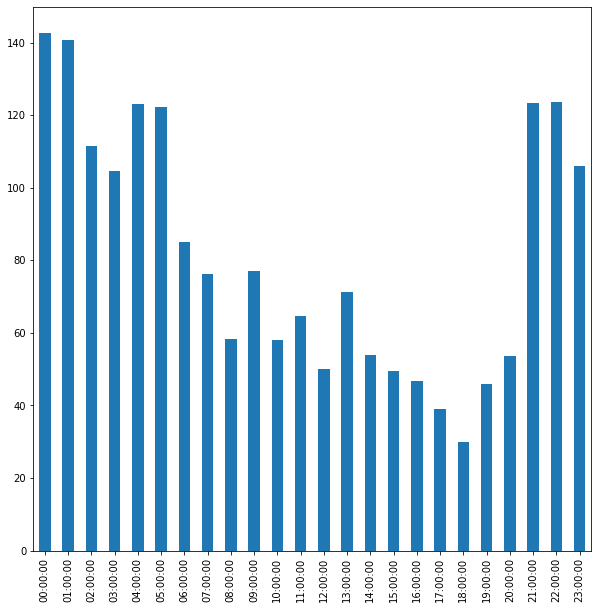

In [170]:
by_hour = df_5min.groupby(lambda x: datetime.time(hour=x.hour)).mean()
by_hour['sleep_minutes'].plot.bar(figsize=(10,10))

分布を確認

In [171]:
df_5min[df_5min['mothermilk'] > 0]['mothermilk'].describe()

count    368.000000
mean      39.331522
std       66.304753
min        3.000000
25%       12.000000
50%       17.000000
75%       27.000000
max      462.000000
Name: mothermilk, dtype: float64

In [172]:
df_5min[df_5min['milk'] > 0]['milk'].describe()

count     33.000000
mean      98.484848
std       28.627043
min       50.000000
25%      100.000000
50%      100.000000
75%      120.000000
max      200.000000
Name: milk, dtype: float64

In [173]:
df_5min[df_5min['expressedmilk'] > 0]['expressedmilk'].describe()

count      3.000000
mean      73.333333
std       25.166115
min       50.000000
25%       60.000000
50%       70.000000
75%       85.000000
max      100.000000
Name: expressedmilk, dtype: float64

In [174]:
df_5min[df_5min['sleep_minutes'] > 0]['sleep_minutes'].describe()

count    276.000000
mean      83.615942
std       67.067274
min        5.000000
25%       30.000000
50%       65.000000
75%      125.000000
max      475.000000
Name: sleep_minutes, dtype: float64

ある時刻より前の最後のイベントを取得する関数

In [175]:
def last_event_by(df, time, column):
    rows = df[:time][df[:time][column] > 0]
    if len(rows) == 0:
        return 0, 0, 0
    row = rows.iloc[-1]
    delta = time - row.name
    return row.name, row[column], delta.total_seconds() / 60

last_event_by(df_5min, pd.to_datetime('2020-10-02 03:00'), 'mothermilk')

(Timestamp('2020-10-02 02:30:00'), 20.0, 30.0)

睡眠時間と、その直前の各種イベントの内容をデータセット化

In [176]:
sleep_df = pd.DataFrame(columns=['datetime', 'hour', 'sleep_minutes', 'last_mothermilk', 'last_mothermilk_before', 'last_milk', 'last_milk_before', 'last_small_before', 'last_big_before'])

for index, row in df_5min.iterrows():
    if row['sleep_minutes'] > 0:
        mothermilk_time, mothermilk, mothermilk_before = last_event_by(df_5min, index, 'mothermilk')
        milk_time, milk, milk_before = last_event_by(df_5min, index, 'milk')
        small_time, small, small_before = last_event_by(df_5min, index, 'small')
        big_time, big, big_before = last_event_by(df_5min, index, 'big')
        sleep_df = sleep_df.append({
            'datetime': index,
            'hour': index.hour,
            'sleep_minutes': row['sleep_minutes'],
            'last_mothermilk': mothermilk,
            'last_mothermilk_before': mothermilk_before,
            'last_milk': milk,
            'last_milk_before': milk_before,
            'last_small_before': small_before,
            'last_big_before': big_before
        }, ignore_index=True)

sleep_df

,datetime,hour,sleep_minutes,last_mothermilk,last_mothermilk_before,last_milk,last_milk_before,last_small_before,last_big_before
0,2020-10-01 08:55:00,8,25.0,9.0,10.0,0,0,65.0,65.0
1,2020-10-01 10:15:00,10,100.0,9.0,90.0,0,0,145.0,145.0
2,2020-10-01 13:10:00,13,55.0,17.0,75.0,0,0,30.0,320.0
3,2020-10-01 14:35:00,14,80.0,26.0,25.0,0,0,115.0,405.0
4,2020-10-01 16:20:00,16,5.0,21.0,25.0,0,0,25.0,510.0
...,...,...,...,...,...,...,...,...,...
271,2020-10-31 14:20:00,14,10.0,16.0,0.0,200,1110,5.0,380.0
272,2020-10-31 16:45:00,16,30.0,16.0,145.0,200,1255,150.0,525.0
273,2020-10-31 20:20:00,20,40.0,20.0,25.0,120,40,50.0,740.0
274,2020-10-31 21:05:00,21,45.0,20.0,70.0,120,85,95.0,785.0


In [177]:
sleep_df.to_csv(f'data/preprocessed/sleep_{target}.tsv', sep='\t')